In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
from sklearn.metrics import ConfusionMatrixDisplay

drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/Complaints.csv')
print("Number of nulls in each column\n"+str(df.isna().sum()))
print("\nNumber of duplicated rows = "+str(df.duplicated().sum()))
df['COMPLAINT_TYPE'].unique()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of nulls in each column
CASE_ID                       0
OFFER_NAME                 1293
CUSTOMER_TYPE                 0
CUSTOMER_GROUP             1348
CURRENT_STATUS                0
ESCALATION_FLAG               0
ESCALATED_GROUP            7055
OPEN_DATE                     0
OPEN_USER                   362
CLOSE_DATE                  119
CLOSE_GROUP                4890
CLOSE_USER                  516
AGE_BRACKET                 119
ACTUAL_COMPLAINT              0
CALLBACK_MECHANISM         7277
RESOLUTION                10336
RESOLUTION_DESCRIPTION    10376
CASE_DESC                  9243
OPEN_GR                    4561
COMPLAINT_TYPE                0
PRODUCT                       0
CASE                          0
dtype: int64

Number of duplicated rows = 0


array(['Technical', 'Commercial'], dtype=object)

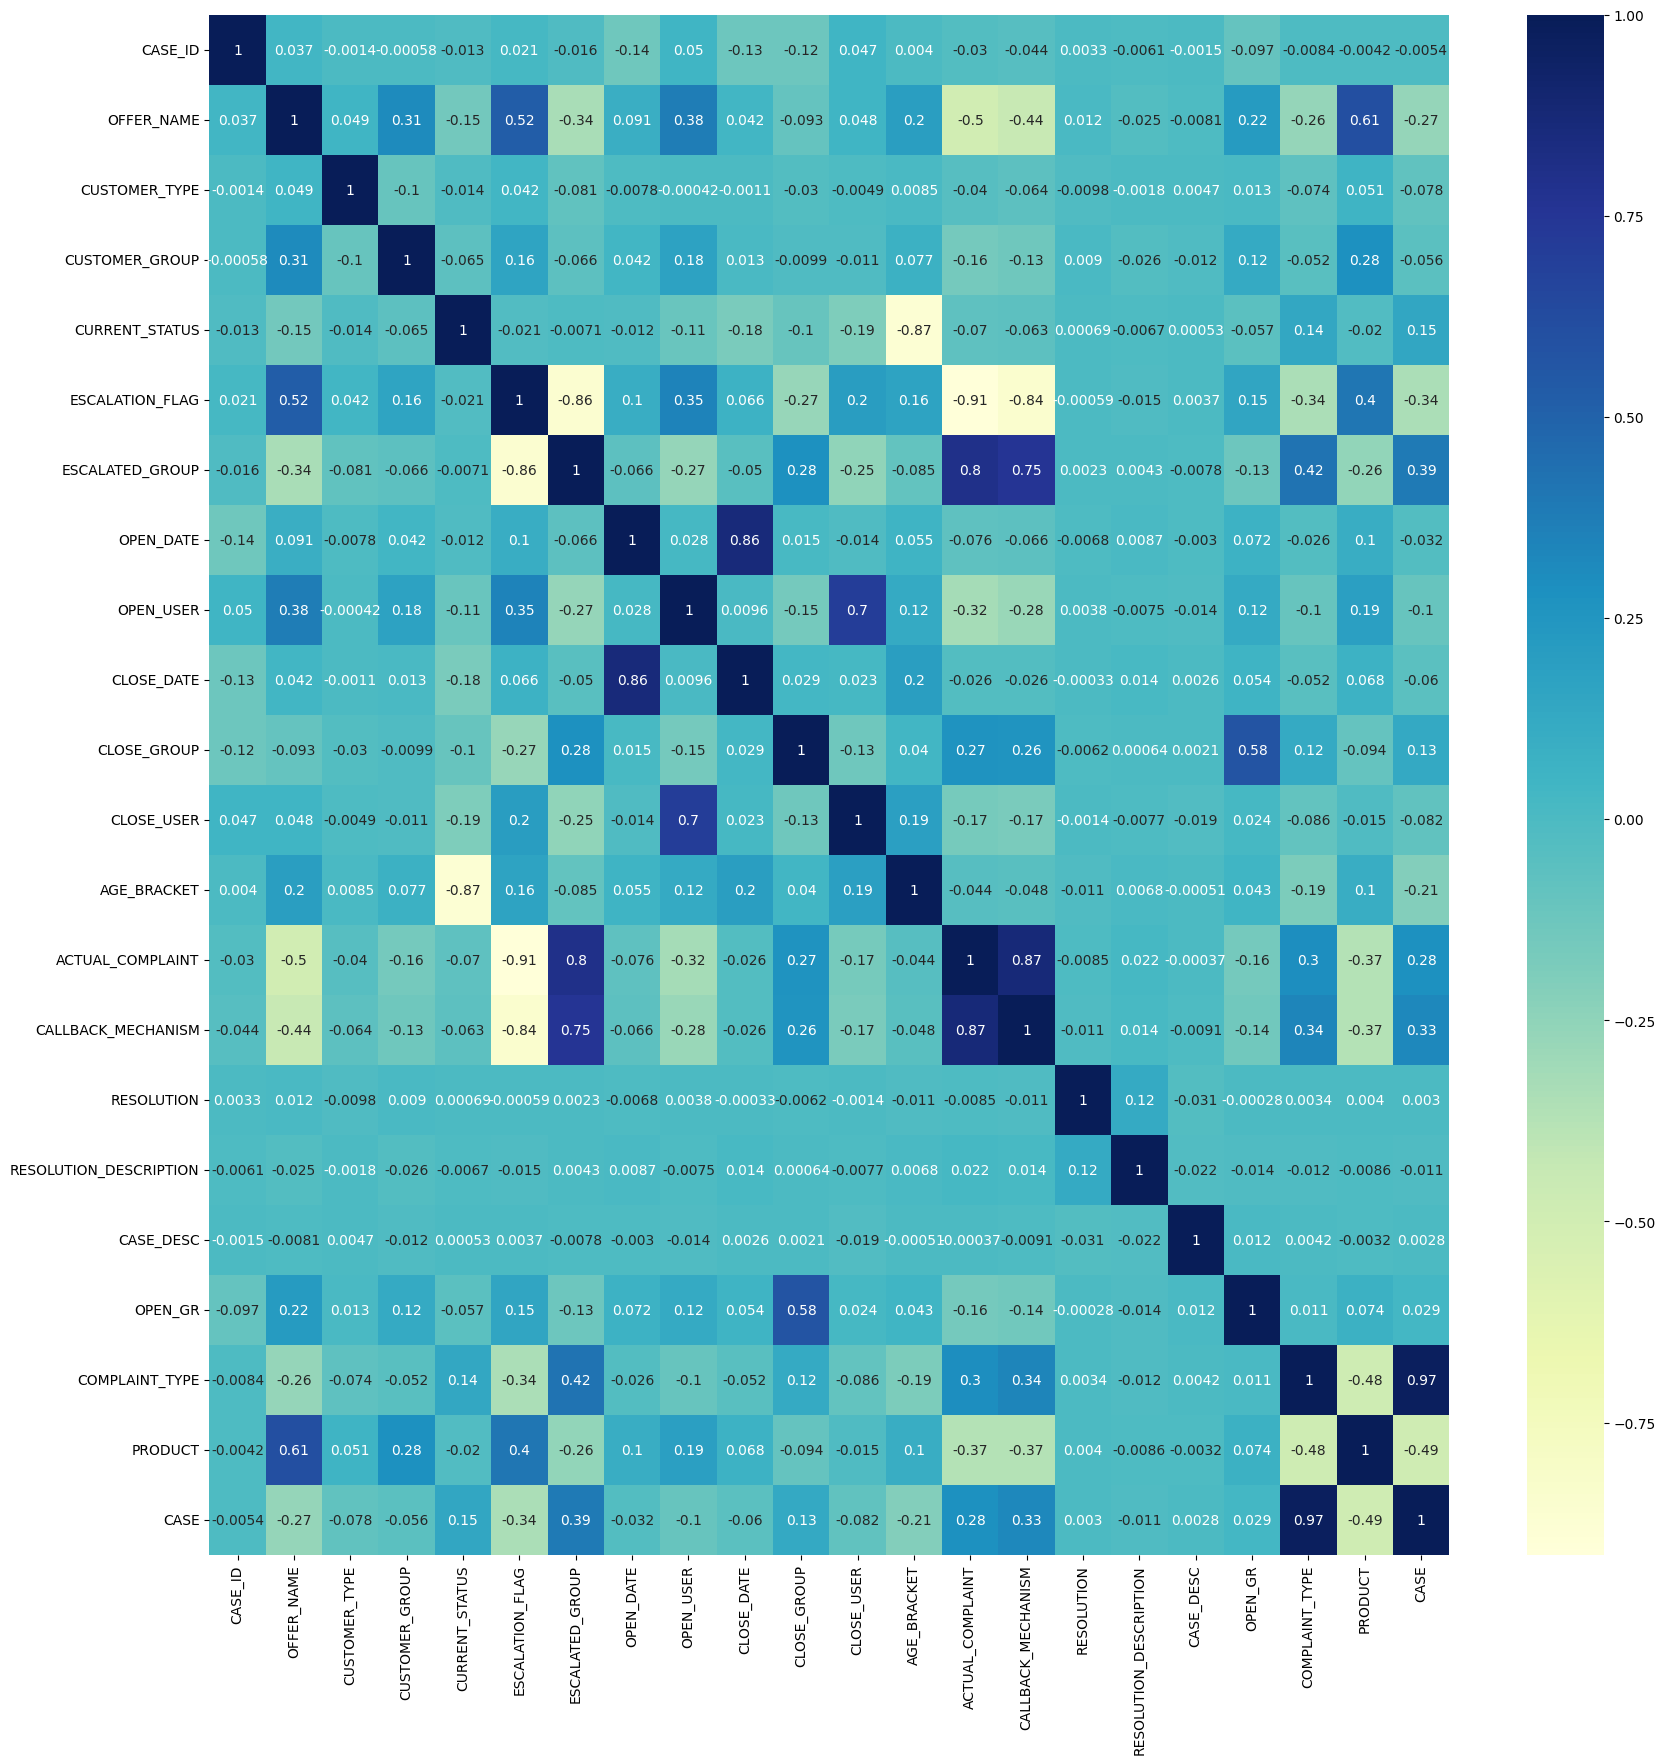

In [ ]:
encoder = LabelEncoder()
df2 = df.copy()
for column in df2.columns:
    df2[column] = encoder.fit_transform(df[column])
fig, ax = plt.subplots(figsize=(20, 20))
dataplot = sb.heatmap(df2.corr(), cmap="YlGnBu", annot=True)

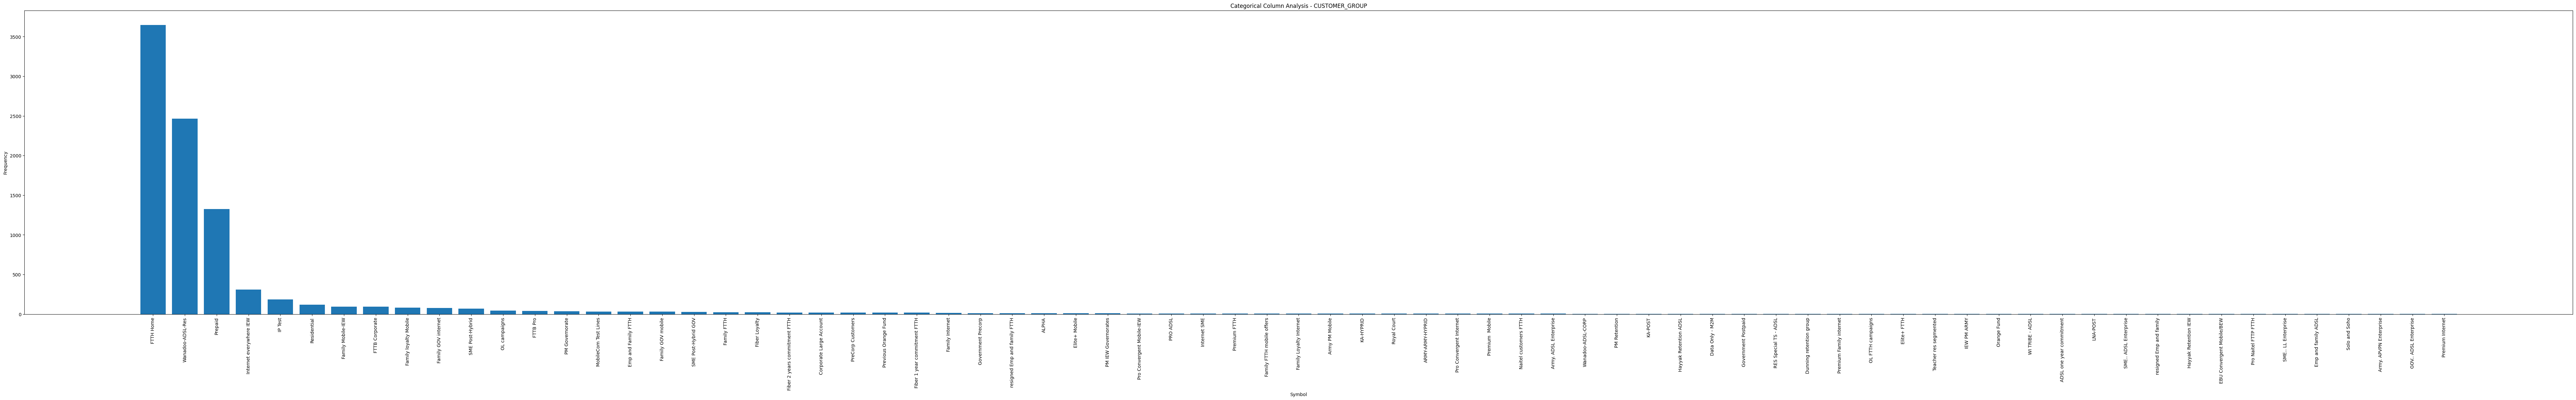

In [ ]:
counts = df['CUSTOMER_GROUP'].value_counts()
plt.figure(figsize=(100, 12))
plt.bar(counts.index, counts.values)
plt.xlabel('Symbol')
plt.ylabel('Frequency')
plt.title('Categorical Column Analysis - CUSTOMER_GROUP')
plt.xticks(rotation=90)
plt.show()

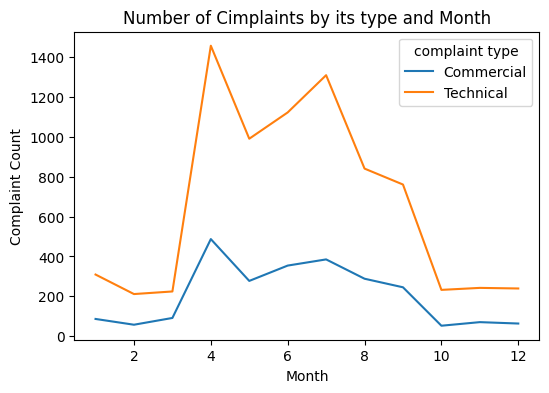

In [ ]:
df['OPEN_DATE'] = pd.to_datetime(df['OPEN_DATE'], errors='coerce')
df['CLOSE_DATE'] = pd.to_datetime(df['CLOSE_DATE'], errors='coerce')
df_monthly_trades = df.groupby([df['OPEN_DATE'].dt.month, 'COMPLAINT_TYPE'])['CASE_ID'].count().reset_index()
df_monthly_trades.columns = ['Month', 'complaint type', 'complaints Count']
plt.figure(figsize=(6, 4))
sns.lineplot(data=df_monthly_trades, x='Month', y='complaints Count', hue='complaint type')
plt.title('Number of Cimplaints by its type and Month')
plt.xlabel('Month')
plt.ylabel('Complaint Count')
plt.show()

In [ ]:
contingency_table= pd.crosstab(df['CUSTOMER_TYPE'], df['COMPLAINT_TYPE'])
print("Contingency Table for  column:")
pd.set_option('display.max_columns', None)
print(contingency_table)

Contingency Table for  column:
COMPLAINT_TYPE  Commercial  Technical
CUSTOMER_TYPE                        
CBU                   2362       7828
EBU                    101        124


# **Preprocessing**

In [ ]:
df=df.drop(["RESOLUTION","RESOLUTION_DESCRIPTION","CASE_DESC","CASE_ID"],axis=1)

In [ ]:
df['OFFER_NAME'] = df.groupby(['CUSTOMER_TYPE', 'PRODUCT', 'CASE'])['OFFER_NAME'].transform(lambda x: x.fillna(x.mode().iat[0]))

In [ ]:
df['CUSTOMER_GROUP'] = df.groupby(['CUSTOMER_TYPE', 'OFFER_NAME','PRODUCT'])['CUSTOMER_GROUP'].transform(lambda x: x.fillna(x.mode().iat[0]))

In [ ]:
df = df.dropna(subset=['CLOSE_USER'])

In [ ]:
df.loc[df['ESCALATION_FLAG'] == "No", 'ESCALATED_GROUP'] = "No escalation group"
df['ESCALATED_GROUP'] = df.groupby(['CASE','CUSTOMER_TYPE','ESCALATION_FLAG'])['ESCALATED_GROUP'].transform(lambda x: x.fillna(x.mode().iat[0]))

<ipython-input-10-f4919444c7c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ESCALATED_GROUP'] = df.groupby(['CASE','CUSTOMER_TYPE','ESCALATION_FLAG'])['ESCALATED_GROUP'].transform(lambda x: x.fillna(x.mode().iat[0]))


In [ ]:
df['CLOSE_GROUP'] = df.groupby(['CASE', 'COMPLAINT_TYPE','ACTUAL_COMPLAINT'])['CLOSE_GROUP'].transform(lambda x: x.fillna(x.mode().iat[0]))

In [ ]:
df['OPEN_GR'] = df.groupby(['CASE'])['OPEN_GR'].transform(lambda x: x.fillna(x.mode().iat[0]))

In [ ]:
df['AGE_BRACKET']=df['AGE_BRACKET'].fillna(-999)
df['CLOSE_DATE']=df['CLOSE_DATE'].fillna(df['OPEN_DATE']-timedelta(days=999))
df = df.dropna(subset=['CLOSE_DATE'])

In [ ]:
df['CALLBACK_MECHANISM']=np.where(df['CURRENT_STATUS']=='Active',"no callback",df['CALLBACK_MECHANISM'])
df.loc[(df['CLOSE_DATE']-df['OPEN_DATE'])<timedelta(seconds=1800), 'CALLBACK_MECHANISM'] = "Phone"
df['CALLBACK_MECHANISM']=df['CALLBACK_MECHANISM'].fillna("no preferred callback mechanism")

<ipython-input-14-0c3e4733b1c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CALLBACK_MECHANISM']=np.where(df['CURRENT_STATUS']=='Active',"no callback",df['CALLBACK_MECHANISM'])
<ipython-input-14-0c3e4733b1c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CALLBACK_MECHANISM']=df['CALLBACK_MECHANISM'].fillna("no preferred callback mechanism")


In [ ]:
df.isnull().sum()

OFFER_NAME            0
CUSTOMER_TYPE         0
CUSTOMER_GROUP        0
CURRENT_STATUS        0
ESCALATION_FLAG       0
ESCALATED_GROUP       0
OPEN_DATE             0
OPEN_USER             0
CLOSE_DATE            0
CLOSE_GROUP           0
CLOSE_USER            0
AGE_BRACKET           0
ACTUAL_COMPLAINT      0
CALLBACK_MECHANISM    0
OPEN_GR               0
COMPLAINT_TYPE        0
PRODUCT               0
CASE                  0
dtype: int64

# **MODELLING**

In [ ]:
label_encoder = LabelEncoder()

df=df.astype(str)
cat_columns = df.select_dtypes(['object']).columns
df[cat_columns] = df[cat_columns].apply(LabelEncoder().fit_transform)

In [ ]:
df.head()
x = df.drop(["PRODUCT"], axis=1)

y = df["PRODUCT"]

### ***Random*** **Forest**

In [ ]:
rf = RandomForestClassifier()
sum_RF_acc = []
sum_RF_pre = []
sum_RF_rec = []
sum_RF_f1 = []
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=i)
    # Performing training
    rf.fit(X_train, y_train)
    #Calculate predictions (y_pred) using X_test
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    sum_RF_acc.append(acc)
    rec = recall_score(y_test,y_pred)
    sum_RF_rec.append(rec)
    pre =  precision_score(y_test,y_pred)
    sum_RF_pre.append(pre)
    f1 = f1_score(y_test,y_pred)
    sum_RF_f1.append(f1)

avg_RF_acc=sum(sum_RF_acc)*2
avg_RF_rec=sum(sum_RF_rec)*2
avg_RF_pre=sum(sum_RF_pre)*2
avg_RF_f1=sum(sum_RF_f1)*2

print('Average Accuracy:',avg_RF_acc )
print('Average Recall:', avg_RF_rec)
print('Average Precision:', avg_RF_pre)
print('Average F1-Score:', avg_RF_f1)


Average Accuracy: 99.50283400809715
Average Recall: 99.23440754416637
Average Precision: 99.03906055092979
Average F1-Score: 99.135934065872


# **visualization**

### **Bar** **chart**

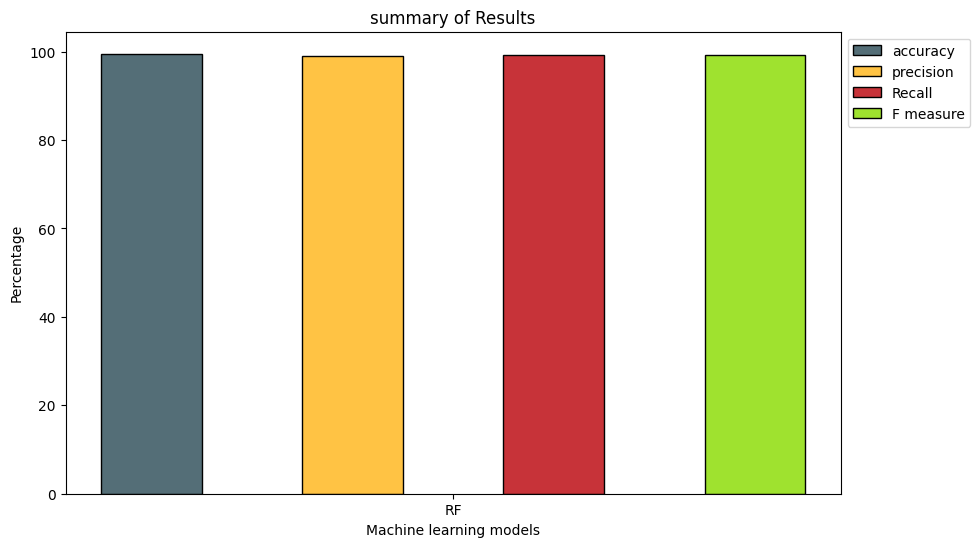

In [ ]:
machine_learning_model_name = ['RF']
machine_learning_model_acc=[avg_RF_acc]
machine_learning_model_rec = [avg_RF_rec]
machine_learning_model_pre = [avg_RF_pre]
machine_learning_model_F1 = [avg_RF_f1]
X_axis = np.arange(len(machine_learning_model_name ))

plt.figure(figsize=(10, 6))

plt.bar(X_axis+0, machine_learning_model_acc, color ="#546E77",width = 0.1,edgecolor = 'black',label = 'accuracy')
plt.bar(X_axis+0.2, machine_learning_model_pre, color ='#FFC344',width = 0.1,edgecolor = 'black',label = 'precision')
plt.bar(X_axis + 0.4, machine_learning_model_rec, color ='#C73339',width = 0.1,edgecolor = 'black',label = 'Recall')
plt.bar(X_axis + 0.6, machine_learning_model_F1, color ='#9FE22F',width = 0.1,edgecolor = 'black',label = 'F measure')
plt.xticks(X_axis+0.3, machine_learning_model_name )
plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Machine learning models")
plt.ylabel("Percentage")
plt.title("summary of Results")
plt.show()

### **Boxplot chart**

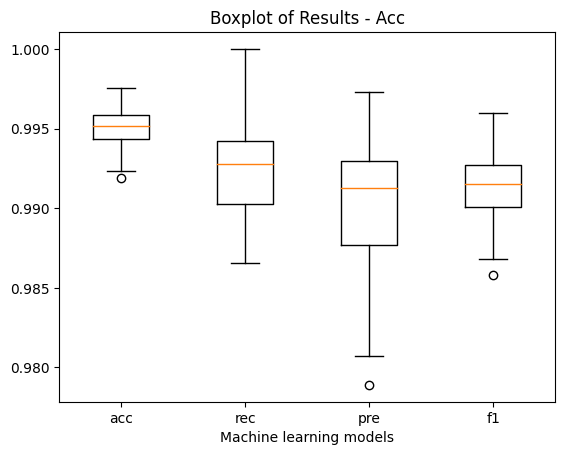

In [ ]:
data2 = [  sum_RF_acc, sum_RF_rec,sum_RF_pre,sum_RF_f1]
data2_names = ['acc','rec','pre','f1']
plt.boxplot(data2)
X_axis = np.arange(len(data2_names ))
plt.xticks(X_axis+1, data2_names )
plt.xlabel("Machine learning models")
plt.title("Boxplot of Results - Acc")
plt.show()

### **Radar** **chart**

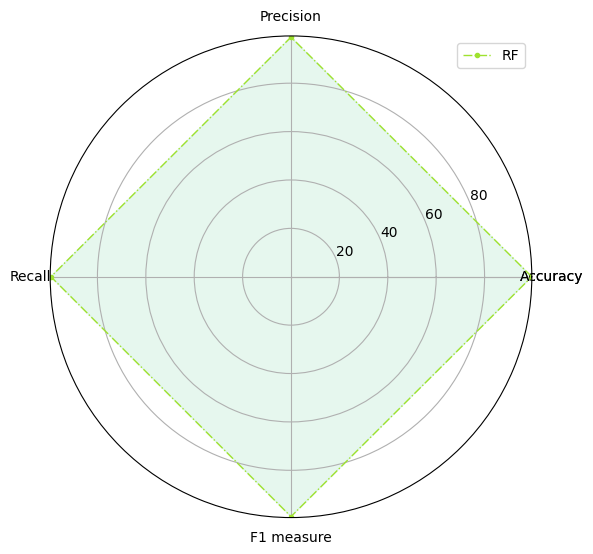

In [ ]:
subjects=['Accuracy','Precision','Recall','F1 measure']
RF=[avg_RF_acc,avg_RF_pre,avg_RF_rec,avg_RF_f1]

angles=np.linspace(0,2*np.pi,len(subjects), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
subjects.append(subjects[0])
RF.append(RF[0])

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111, polar=True)


ax.plot(angles,RF,'.-.' , color='#9FE22F', linewidth=1, label='RF')
ax.fill(angles, RF, alpha=0.25, color='#9FE2BF')

ax.set_thetagrids(angles * 180/np.pi, subjects)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# **Neural Networks**

In [ ]:
model = Sequential()

model.add(Dense(50, activation='tanh'))
model.add(Dense(25, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, verbose=1)

Epoch 1/3
232/232 [==============================] - 3s 4ms/step - loss: 0.5671 - accuracy: 0.7298
Epoch 2/3
232/232 [==============================] - 1s 4ms/step - loss: 0.5338 - accuracy: 0.7556
Epoch 3/3
232/232 [==============================] - 1s 3ms/step - loss: 0.5526 - accuracy: 0.7471


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                900       
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,201
Trainable params: 2,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pred=model.predict(X_test)

78/78 [==============================] - 0s 3ms/step


In [ ]:
seq_predictions = list(map(lambda x: 0 if x<0.5 else 1, pred))

In [ ]:
print("Accuracy="+'{:.2%}\n'.format(accuracy_score( y_test,seq_predictions)))
print("precision_score="+'{:.2%}\n'.format(precision_score(y_test, seq_predictions)))
print("recall_score="+'{:.2%}\n'.format(recall_score(y_test, seq_predictions)))
print(classification_report(y_test, seq_predictions))

Accuracy=73.93%

precision_score=71.14%

recall_score=14.99%

              precision    recall  f1-score   support

           0       0.74      0.98      0.84      1763
           1       0.71      0.15      0.25       707

    accuracy                           0.74      2470
   macro avg       0.73      0.56      0.54      2470
weighted avg       0.73      0.74      0.67      2470



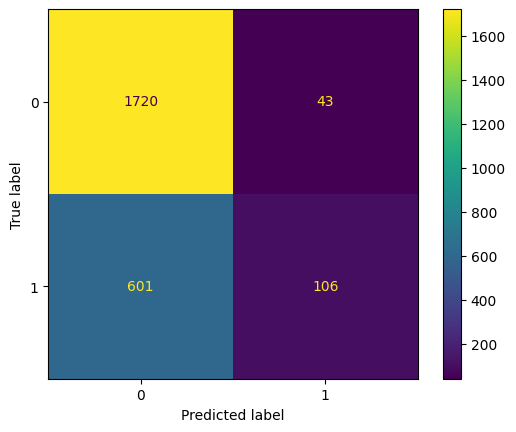

In [ ]:
cm = confusion_matrix(y_test, seq_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

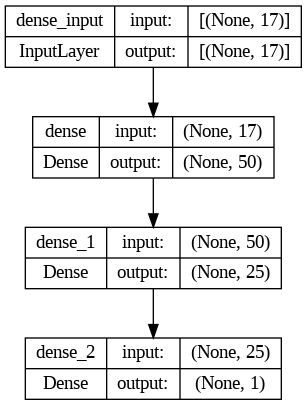

In [ ]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)